## Fraud detection Classifier

Semme Kaandorp <br>
11046244 <br>
University of Amsterdam <br>
March 30, 2020 <br>

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import time 
from collections import Counter
import findspark
import pyspark
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from pyspark.sql import SparkSession #important
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

from pyspark.ml.classification import LogisticRegression

from imblearn import under_sampling, over_sampling
 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [10]:
#import packages for pandas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [11]:
#important source
#https://github.com/lksfr/credit_card_fraud/blob/master/creditcardfraud.ipynb

#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa


### Load data

In [12]:
%%time
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('creditcard.csv', header= True, inferSchema = True)
#df.printSchema()

CPU times: user 5.43 ms, sys: 6.5 ms, total: 11.9 ms
Wall time: 3.56 s


In [18]:
#change Apache dataframe to Pandas Datafame
analysis = pd.DataFrame(df.take(284807), columns=df.columns)

#apparantly time was not a float
analysis['Time'] = analysis['Time'].astype('float64')
frauds = analysis[analysis.Class ==1]

In [19]:
X, y = analysis[list(analysis.columns[1:-1])], analysis['Class']
print('very imbalanced dataset:')
print(Counter(y))

very imbalanced dataset:
Counter({0: 284315, 1: 492})


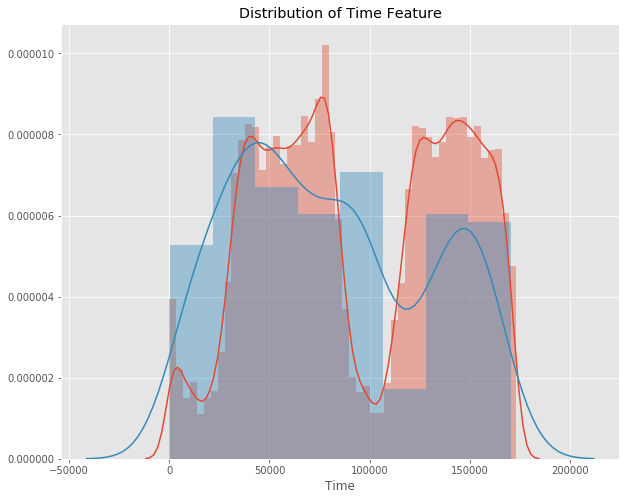

In [20]:
#print distribution of transaction and fraudcases over time

plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(analysis.Time)
sns.distplot(frauds.Time)

# Pandas

### Data Sampling

### None

In [21]:
#NO SAMPLING CONDUCTED

#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=402)
print(Counter(y))

Counter({0: 284315, 1: 492})


### Undersampling

In [22]:
#UNDERSAMPLING, 1>same, 0.1> Min=10x smaller than Maj
undersample = under_sampling.RandomUnderSampler(sampling_strategy=((1/(98/2))))

X_over, y_over = undersample.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print(Counter(y))
print(Counter(y_over))

Counter({0: 284315, 1: 492})
Counter({0: 24108, 1: 492})


### Oversampling

In [23]:
#OVERSAMPLING, 1>same, 0.1> Min=10x smaller than Maj
oversample = over_sampling.RandomOverSampler(sampling_strategy=(1/(50/50)))
X_over, y_over = oversample.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print(Counter(y))
print(Counter(y_over))

Counter({0: 284315, 1: 492})
Counter({0: 284315, 1: 284315})


### SMOTE

In [24]:
#SMOTE (over), 1>same, 0.1> Min=10x smaller than Maj
smote = over_sampling.SMOTE(sampling_strategy=(1/(50/50)))

X_over, y_over = smote.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print(Counter(y))
print(Counter(y_over))

Counter({0: 284315, 1: 492})
Counter({0: 284315, 1: 284315})


### Logistic Regression

In [25]:
#training the algorithm
from sklearn.linear_model import LogisticRegression
lr_reg = LogisticRegression(n_jobs=10)

In [26]:
lr_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
#print table with actual/predicted classes
y_pred = lr_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': lr_reg.predict(X_test).flatten()})
#table.head()
# predict probabilities
lr_probs = lr_reg.predict_proba(X_test)[:,1]
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# calculate scores
lr_prr_auc = auc(lr_recall, lr_precision)

In [28]:
#print metrics
lr_accuracy = lr_reg.score(X_test, y_test)
lr_roc_auc = roc_auc_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='binary')
lr_recall = recall_score(y_test, y_pred, average='binary')

#print('accuracy:', lr_accuracy)
#print('ROC AUC:', lr_roc_auc)
#print('PreRec AUC:', lr_prr_auc)
#print("Precision", lr_precision)
#print("Recall",lr_recall)

In [29]:
print(round(lr_roc_auc, 5))
print(round(lr_prr_auc, 5))
print(round(lr_precision, 5))
print(round(lr_recall, 5))

0.95762
0.99248
0.98301
0.93139


In [30]:
#confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm = metrics.confusion_matrix(y_test, y_pred)
#print('Precision: ', tp/(tp+fp))
#print('Recall: ', tp/(tp+fn))
print(cm)

[[55860   917]
 [ 3907 53042]]


## Random Forest

In [31]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf_reg = RandomForestClassifier(n_estimators = 10, random_state = 41)
# Train the model on training data
rf_reg.fit(X_train, y_train);

In [33]:
rf_reg

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

In [218]:
#print table with actual/predicted classes
y_pred = rf_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': rf_reg.predict(X_test).flatten()})
#table.head()
# predict probabilities
rf_probs = rf_reg.predict_proba(X_test)[:,1]
# keep probabilities for the positive outcome only
#rf_probs = rf_probs[:, 1]
# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
# calculate scores
rf_prr_auc = auc(rf_recall, rf_precision)

In [219]:
rf_accuracy = rf_reg.score(X_test, y_test)
rf_roc_auc = roc_auc_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='binary')
rf_recall = recall_score(y_test, y_pred, average='binary')

# print('accuracy:', rf_accuracy)
# print('ROC AUC:', rf_roc_auc)
print('PreRec AUC:', rf_prr_auc)
print("Precision", rf_precision)
# print("Recall",rf_recall)

PreRec AUC: 0.9999901473939005
Precision 0.9997717656559981


In [220]:
print(round(rf_roc_auc, 5))
print(round(rf_prr_auc, 5))
print(round(rf_precision, 5))
print(round(rf_recall, 5))

0.99986
0.99999
0.99977
0.99995


### Decision Tree

In [221]:
from sklearn import tree
dt_reg = tree.DecisionTreeClassifier()
dt_reg.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [222]:
#print table with actual/predicted classes
y_pred = dt_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': dt_reg.predict(X_test).flatten()})
#table.head()
# predict probabilities
dt_probs = dt_reg.predict_proba(X_test)[:,1]
# keep probabilities for the positive outcome only
#rf_probs = rf_probs[:, 1]
# calculate precision and recall for each threshold
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_probs)
# calculate scores
dt_prr_auc = auc(dt_recall, dt_precision)

In [223]:
dt_accuracy = dt_reg.score(X_test, y_test)
dt_roc_auc = roc_auc_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred, average='binary')
dt_recall = recall_score(y_test, y_pred, average='binary')

In [224]:
print(round(dt_roc_auc, 5))
print(round(dt_prr_auc, 5))
print(round(dt_precision, 5))
print(round(dt_recall, 5))

0.99834
0.99855
0.99753
0.99916


# KLAAAR

# KLAAAR

In [ ]:
#NO SAMPLING CONDUCTED
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=402)
print(Counter(y_test))

In [ ]:
#training the algorithm
from sklearn.linear_model import LogisticRegression
lr_reg = LogisticRegression(n_jobs=10)

lr_reg.fit(X_train, y_train)

In [ ]:
# fit a model
#model = LogisticRegression(solver='lbfgs')
#model.fit(trainX, trainy)

# predict probabilities
lr_probs = lr_reg.predict_proba(X_test)


In [ ]:
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
#ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))


In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99,0.01], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
# calculate scores
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Apache

In [11]:
#import packages for apache
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

bin_evaluator = BinaryClassificationEvaluator()
multi_evaluator = MulticlassClassificationEvaluator()

### Prepare data

In [12]:
df = spark.createDataFrame(analysis)

In [13]:
vectorAssembler = VectorAssembler(inputCols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13',
'V14','V15','V16','V17','V18','V19','V20','V21','V22', 'V23','V24','V25','V26','V27','V28','Amount'], outputCol = 'features')

df1 = vectorAssembler.transform(df)
df2 = df1.select(['features', 'Class'])
df3 = df2.withColumnRenamed("Class","label")

In [14]:
#randomly split data in train/test set
#validation set is not necessary since we're dealing with large amounts of data

train, test = df3.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 227858
Test Dataset Count: 56949


## Logistic Regression

In [15]:
lr = LogisticRegression(maxIter=10)#, regParam=0.2, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

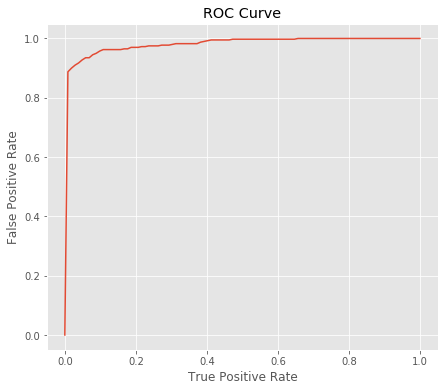

Training set areaUnderROC: 0.9711006483849487


In [25]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.figure(figsize=(7,6))
plt.plot(roc['FPR'],roc['TPR'])

plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(bin_evaluator.evaluate(lr_predictions)))

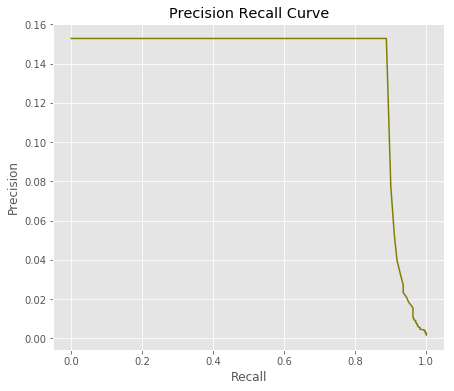

Training set areaUnderPR: 0.7207599913448862


In [28]:
pr = trainingSummary.pr.toPandas()
plt.figure(figsize=(7,6))
plt.plot(pr['recall'],pr['precision'], color='olive')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision Recall Curve')
plt.show()
print('Training set areaUnderPR: ' + str(bin_evaluator.evaluate(lr_predictions, {bin_evaluator.metricName: "areaUnderPR"})))

In [18]:
lr_predictions = lrModel.transform(test)
lr_predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-27.84818067198,...|    1|[0.81640192543287...|[0.69347203541465...|       0.0|
|[-24.465548667359...|    0|[8.62905655492298...|[0.99982119869064...|       0.0|
|[-23.237920244511...|    1|[-2.0502865712633...|[0.11402342805069...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



In [ ]:
print("Linear Regression")
print('AUC ROC: ', round(bin_evaluator.evaluate(lr_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(lr_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))

In [ ]:
Linear Regression
AUC ROC:  0.9831
AUC PR:   0.8273

## Dicision Tree

In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [ ]:
dt_predictions = dtModel.transform(test)
dt_predictions.show(3)

In [ ]:
print("Decision Tree")
print('AUC ROC: ', round(bin_evaluator.evaluate(dt_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(dt_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))

In [ ]:
AUC ROC:  0.7457
AUC PR:   0.7213

## Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(train)

In [ ]:
rf_predictions = rfModel.transform(test)
rf_predictions.show(3)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Random Forest")
print('AUC ROC: ', round(bin_evaluator.evaluate(rf_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(rf_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))
print('F1: ', round(multi_evaluator.evaluate(rf_predictions),4))

## Analysis RUS & ROS

In [ ]:
#OVERSAMPLING, 1>same, 0.1> Min=10x smaller than Maj
oversample = over_sampling.RandomOverSampler(sampling_strategy=0.1)

X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)

X_over, y_over = oversample.fit_resample(X, y)

print(Counter(y))
print(Counter(y_over))

In [ ]:
#UNDERSAMPLING, 1>same, 0.1> Maj=10x smaller than Min
undersample = RandomUnderSampler(sampling_strategy=0.1)

X, y = make_classification(n_samples=1000, weights=[0.99], flip_y=0)

X_over, y_over = undersample.fit_resample(X, y)

print(Counter(y))
print(Counter(y_over))

In [ ]:
undersample

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(n_samples=10000, weights=[0.99], flip_y=0)
# summarize class distribution
print(Counter(y))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))